# 搭建多层的 GRU 网络实现 MNIST 分类

在上个例子中，我们已经理解了在 TensorFlow 中如何来实现 LSTM， 在本例子中来实现以下 GRU。和 LSTM 基本上一样，只是基本模型换成了 GRU。

In [1]:
import warnings
warnings.filterwarnings('ignore')  # 不打印 warning 

import tensorflow as tf

# 设置GPU按需增长
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

import numpy as np

# 用tensorflow 导入数据
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/MNIST_data', one_hot=True) 

# 看看咱们样本的数量
print(mnist.test.labels.shape)
print(mnist.train.labels.shape)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(10000, 10)
(55000, 10)


 ** 一、首先设置好模型用到的各个超参数 **

In [2]:
lr = 1e-3
input_size = 28      # 每个时刻的输入特征是28维的，就是每个时刻输入一行，一行有 28 个像素
timestep_size = 28   # 时序持续长度为28，即每做一次预测，需要先输入28行
hidden_size = 256    # 隐含层的数量
layer_num = 2        # LSTM layer 的层数
class_num = 10       # 最后输出分类类别数量，如果是回归预测的话应该是 1
cell_type = "block_gru"   # gru 或者 block_gru

X_input = tf.placeholder(tf.float32, [None, 784])
y_input = tf.placeholder(tf.float32, [None, class_num])
# 在训练和测试的时候，我们想用不同的 batch_size.所以采用占位符的方式
batch_size = tf.placeholder(tf.int32, [])  # 注意类型必须为 tf.int32, batch_size = 128
keep_prob = tf.placeholder(tf.float32, [])

 ** 二、开始搭建 GRU 模型，和 LSTM 模型基本一致 **

In [3]:
# 把784个点的字符信息还原成 28 * 28 的图片
# 下面几个步骤是实现 RNN / gru 的关键

# **步骤1：RNN 的输入shape = (batch_size, timestep_size, input_size) 
X = tf.reshape(X_input, [-1, 28, 28])

# ** 步骤2：创建 gru 结构
def gru_cell(cell_type, num_nodes, keep_prob):
    assert(cell_type in ["gru", "block_gru"], "Wrong cell type.")
    if cell_type == "gru":
        cell = tf.contrib.rnn.GRUCell(num_nodes)
    else:
        cell = tf.contrib.rnn.GRUBlockCellV2(num_nodes)
    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

mgru_cell = tf.contrib.rnn.MultiRNNCell([gru_cell(cell_type, hidden_size, keep_prob) for _ in range(layer_num)], state_is_tuple = True)

# **步骤3：用全零来初始化state
init_state = mgru_cell.zero_state(batch_size, dtype=tf.float32)

# **步骤4：方法一，调用 dynamic_rnn() 来让我们构建好的网络运行起来
# ** 当 time_major==False 时， outputs.shape = [batch_size, timestep_size, hidden_size] 
# ** 所以，可以取 h_state = outputs[:, -1, :] 作为最后输出
# ** state.shape = [layer_num, 2, batch_size, hidden_size], 
# ** 或者，可以取 h_state = state[-1][1] 作为最后输出
# ** 最后输出维度是 [batch_size, hidden_size]
# outputs, state = tf.nn.dynamic_rnn(mgru_cell, inputs=X, initial_state=init_state, time_major=False)
# h_state = state[-1][1]

# # *************** 为了更好的理解 gru 工作原理，我们把上面 步骤6 中的函数自己来实现 ***************
# # 通过查看文档你会发现， RNNCell 都提供了一个 __call__()函数，我们可以用它来展开实现gru按时间步迭代。
# # **步骤4：方法二，按时间步展开计算
outputs = list()
state = init_state
with tf.variable_scope('RNN'):
    for timestep in range(timestep_size):
        (cell_output, state) = mgru_cell(X[:, timestep, :],state)
        outputs.append(cell_output)
h_state = outputs[-1]

 ** 三、最后设置 loss function 和 优化器，展开训练并完成测试 **

In [4]:
import time 

# 开始训练和测试
W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1,shape=[class_num]), dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(h_state, W) + bias)


# 损失和评估函数
cross_entropy = -tf.reduce_mean(y_input * tf.log(y_pre))
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y_input,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


sess.run(tf.global_variables_initializer())
time0 = time.time()
for i in range(5000):
    _batch_size=100
    X_batch, y_batch = mnist.train.next_batch(batch_size=_batch_size)
    cost, acc,  _ = sess.run([cross_entropy, accuracy, train_op], feed_dict={X_input: X_batch, y_input: y_batch, keep_prob: 0.5, batch_size: _batch_size})
    if (i+1) % 500 == 0:
        # 分 100 个batch 迭代
        test_acc = 0.0
        test_cost = 0.0
        N = 100
        for j in range(N):
            X_batch, y_batch = mnist.test.next_batch(batch_size=_batch_size)
            _cost, _acc = sess.run([cross_entropy, accuracy], feed_dict={X_input: X_batch, y_input: y_batch, keep_prob: 1.0, batch_size: _batch_size})
            test_acc += _acc
            test_cost += _cost
        print("step {}, train cost={:.6f}, acc={:.6f}; test cost={:.6f}, acc={:.6f}; pass {}s".format(i+1, cost, acc, test_cost/N, test_acc/N, time.time() - time0))
        time0 = time.time()

step 500, train cost=0.012643, acc=0.980000; test cost=0.011262, acc=0.964400; pass 11.324278831481934s
step 1000, train cost=0.006675, acc=0.980000; test cost=0.007146, acc=0.976100; pass 10.350492238998413s
step 1500, train cost=0.006741, acc=0.970000; test cost=0.005976, acc=0.981800; pass 10.223833799362183s
step 2000, train cost=0.014265, acc=0.940000; test cost=0.005539, acc=0.983600; pass 10.121492385864258s
step 2500, train cost=0.000602, acc=1.000000; test cost=0.004548, acc=0.986300; pass 10.094793796539307s
step 3000, train cost=0.003602, acc=0.990000; test cost=0.004053, acc=0.989000; pass 10.224550247192383s
step 3500, train cost=0.003195, acc=0.990000; test cost=0.004875, acc=0.985200; pass 10.053868293762207s
step 4000, train cost=0.003112, acc=0.990000; test cost=0.004069, acc=0.989200; pass 10.328427076339722s
step 4500, train cost=0.003034, acc=0.990000; test cost=0.004045, acc=0.988600; pass 10.144667387008667s
step 5000, train cost=0.001717, acc=0.990000; test cost=

和前面 lstm 的例子比较一下，二者的准确率并没有太大的差别; 速度没有明显区别；显存占用也没有明显的区别。

## 四、可视化看看 GRU 的是怎么做分类的

毕竟 GRU更多的是用来做时序相关的问题，要么是文本，要么是序列预测之类的，所以很难像 CNNs 一样非常直观地看到每一层中特征的变化。在这里，我想通过可视化的方式来帮助大家理解 GRU 是怎么样一步一步地把图片正确的给分类。

In [5]:
# 手写的结果 shape
_batch_size = 5
X_batch, y_batch = mnist.test.next_batch(_batch_size)
print(X_batch.shape, y_batch.shape)
_outputs, _state = np.array(sess.run([outputs, state],feed_dict={
            X_input: X_batch, y_input: y_batch, keep_prob: 1.0, batch_size: _batch_size}))
print('_outputs.shape =', np.asarray(_outputs).shape)
print('arr_state.shape =', np.asarray(_state).shape)
# 可见 outputs.shape = [ batch_size, timestep_size, hidden_size]
# state.shape = [layer_num, 2, batch_size, hidden_size]

(5, 784) (5, 10)
_outputs.shape = (28, 5, 256)
arr_state.shape = (2, 5, 256)


In [6]:
import matplotlib.pyplot as plt

X3 = mnist.train.images[5]
img3 = X3.reshape([28, 28])
plt.imshow(img3, cmap='gray')
plt.show()

<Figure size 640x480 with 1 Axes>

我们看看在分类的时候，一行一行地输入，分为各个类别的概率会是什么样子的。

In [7]:
X3.shape = [-1, 784]
y_batch = mnist.train.labels[0]
y_batch.shape = [-1, class_num]

X3_outputs = np.array(sess.run(outputs, feed_dict={
            X_input: X3, y_input: y_batch, keep_prob: 1.0, batch_size: 1}))
print(X3_outputs.shape)
X3_outputs.shape = [28, hidden_size]
print(X3_outputs.shape)

(28, 1, 256)
(28, 256)


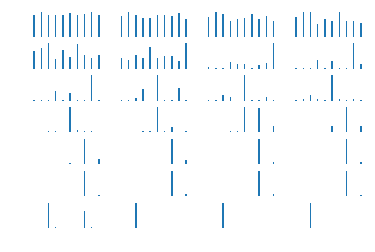

In [8]:
h_W, h_bias = sess.run([W, bias], feed_dict={
            X_input:X3, y_input: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias = h_bias.reshape([-1, 10])

bar_index = range(class_num)
for i in range(X3_outputs.shape[0]):
    plt.subplot(7, 4, i+1)
    X3_h_shate = X3_outputs[i, :].reshape([-1, hidden_size])
    pro = sess.run(tf.nn.softmax(tf.matmul(X3_h_shate, h_W) + h_bias))
    plt.bar(bar_index, pro[0], width=0.2 , align='center')
    plt.axis('off')
plt.show()

在上面的图中，为了更清楚地看到线条的变化，我把坐标都去了，每一行显示了 4 个图，共有 7 行，表示了一行一行读取过程中，模型对字符的识别。可以看到，在只看到前面的几行像素时，模型根本认不出来是什么字符，随着看到的像素越来越多，最后就基本确定了字符的类别